<a href="https://colab.research.google.com/github/bobbyinfj/nlp-recommender/blob/main/2_Sampling_Training_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup
This notebook is best viewed using Colab's Dark Theme (Tools->Settings->Site->Theme->Dark)

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [ ]:
#AdamW optimizer from tensorflow/models.
!pip install -q tf-models-official

In [ ]:
from google.colab import drive, files

import os
import time
import shutil
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from official.nlp import optimization  # to create AdamW optmizer
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
tf.get_logger().setLevel('ERROR')

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
random_state=42
np.random.seed(random_state)

In [ ]:
#mount google drive
drive.mount('/content/gdrive')

#define project path
path = '/content/gdrive/My Drive/Inspire/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_pickle(path+'news.pkl')

In [ ]:
#randomly select X users to prototype code
sample= np.random.choice(df.user_id.unique(), 5000, replace=False)

#filter df based on sampled users
df = df[df['user_id'].isin(sample)]

#Train, Validation, Test Data Splitting
The model was split into 60/20/20 Train, Validation, and Holdout (Test) splits. Data was shuffled, and stratified on users to ensure a random, balanced dataset with meaningful predictions per user. (The balance of the target variable “click” was manually verified, but left out of the stratification to allow for users without both click labels to be included in the dataset.)

In [ ]:
#fill na of abstract column with ""
df.abstract = df.abstract.fillna("")
df.isnull().value_counts()

user_id  item   click  size   title  abstract
False    False  False  False  False  False       613081
dtype: int64

In [ ]:
##Stratifying on multiple columns (user_id and click) of data

# create dummy data with unbalanced feature value distribution
X = df.drop("click", axis=1)
y = df.pop("click")

# split stratified to target variable and subreddit col
X_train, X_test, y_train, y_test = train_test_split(
    X, pd.concat([X["user_id"], y], axis=1), stratify=X["user_id"], test_size=0.2, random_state=random_state)

# remove user_id cols from target variable arrays
y_train = y_train.drop(["user_id"], axis=1)
y_test = y_test.drop(["user_id"], axis=1)

#Split the trainset into train and validation
# Use a utility from sklearn to split and shuffle our dataset.
# split stratified to target variable and user_id col
X_train, X_val, y_train, y_val = train_test_split(
    X_train, pd.concat([X_train["user_id"], y_train], axis=1), stratify=X_train["user_id"], random_state=random_state)

# remove user_id cols from target variable arrays
y_train = y_train.drop(["user_id"], axis=1)
y_val = y_val.drop(["user_id"], axis=1)

In [ ]:
# X_train.head()
y_train.head()
X_val.head()
y_val.head()
X_test.head()
y_test.head()

,click
4052459,0
719094,0
4066170,0
3835760,0
2850761,0


##Verify balance of click variable in dataset

In [ ]:
y_train.click.value_counts(normalize=True)

0    0.804694
1    0.195306
Name: click, dtype: float64

In [ ]:
y_test.click.value_counts(normalize=True)

0    0.8036
1    0.1964
Name: click, dtype: float64

In [ ]:
y_val.click.value_counts(normalize=True)

0    0.804006
1    0.195994
Name: click, dtype: float64

In [ ]:
X_train.isnull().value_counts()

user_id  item   size   title  abstract
False    False  False  False  False       367848
dtype: int64

##Create tf.datasets

In [ ]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
#modified from: https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers
def df_to_dataset(dataframe, labels, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe), seed=random_state)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
#Create train, validation, and test datasets
#prefetch cache datasets for better performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32

train_ds = df_to_dataset(X_train, y_train, batch_size=batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = df_to_dataset(X_val, y_val, batch_size=batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = df_to_dataset(X_test, y_test, batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of abstracts:', train_features['abstract'])
print('A batch of titles:', train_features['title'])
print('A batch of items:', train_features['item'])
print('A batch of sizes:', train_features['size'])
print('A batch of user_ids:', train_features['user_id'])
print('A batch of targets:', label_batch )

Every feature: ['user_id', 'item', 'size', 'title', 'abstract']
A batch of abstracts: tf.Tensor(
[b'Nearly three years after California legalized marijuana, the profit outlook for this budding business looks cloudy.'
 b"This complex used to be home to the US's largest land-based missile, Titan II, which sat there armed for 24 years. Now, it's on sale."
 b'Stacker counts down the top 100 country songs of all time. From old-school honky-tonk to modern country pop, this list covers the biggest hits in Billboard history.'
 b"Though the price is widely known, there are some facts about Costco's most popular poultry that you might not know."
 b'Find out where you can get parcels of land for $10,000 or less.'
 b"As you age, you're at a higer risk for heart disease, diabetes, and muscle loss. Here's a list of 40 restaurant dishes to avoid after 40."
 b'A Houston prosecutor was fired Friday after he allegedly refused to bring charges against a man accused of attempted sexual assault because he 

#BERT Model


##Loading Bert Models from Tensorflow Hub
https://www.tensorflow.org/tutorials/text/classify_text_with_bert

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/2',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2


##BERT Preprocess Module

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

##BERT model

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

#Define model

In [ ]:
def build_classifier_model():
    title_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='title')
    abstract_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='abstract')
    text_input = tf.strings.join([title_input, abstract_input], separator=' ', name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']

    # We set up a large number of bins to reduce the chance of hash collisions.
    num_user_hashing_bins = 50100
    num_item_hashing_bins = 52000

    user_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='user_id')
    item_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='item')

    user_hashing = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=num_user_hashing_bins)(user_input)
    item_hashing = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=num_item_hashing_bins)(item_input)

    user_embedding = tf.keras.layers.Embedding(
        input_dim=num_user_hashing_bins,
        output_dim=32
    )(user_hashing)

    item_embedding = tf.keras.layers.Embedding(
        input_dim=num_item_hashing_bins,
        output_dim=32
    )(item_hashing)

    #Shallow Module
    # Merge the layers with a dot product along the second axis 
    # (shape will be (None, 1, 1))
    fm = tf.keras.layers.Dot(name = 'dot_product', normalize = True, 
    axes = (1,1))([user_embedding, item_embedding])
    # Reshape to be a single number (shape will be (None, 1))
    fm = tf.keras.layers.Reshape(target_shape = [1])(fm)

    conc = tf.keras.layers.Concatenate()([user_embedding, item_embedding, net])
    net = tf.keras.layers.Dropout(0.1)(conc)
    dense = tf.keras.layers.Dense(576, activation='relu')(net)    
    net = tf.keras.layers.Dropout(0.1)(dense)
    dense = tf.keras.layers.Dense(288, activation='relu')(net)
    drop2 = tf.keras.layers.Dropout(0.1)(dense)
    dense = tf.keras.layers.Dense(144, activation='relu')(drop2)

    final_concat = tf.keras.layers.Concatenate()([dense, fm])
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(final_concat)
    return tf.keras.Model([title_input, abstract_input, user_input, item_input], out)

In [ ]:
classifier_model = build_classifier_model()

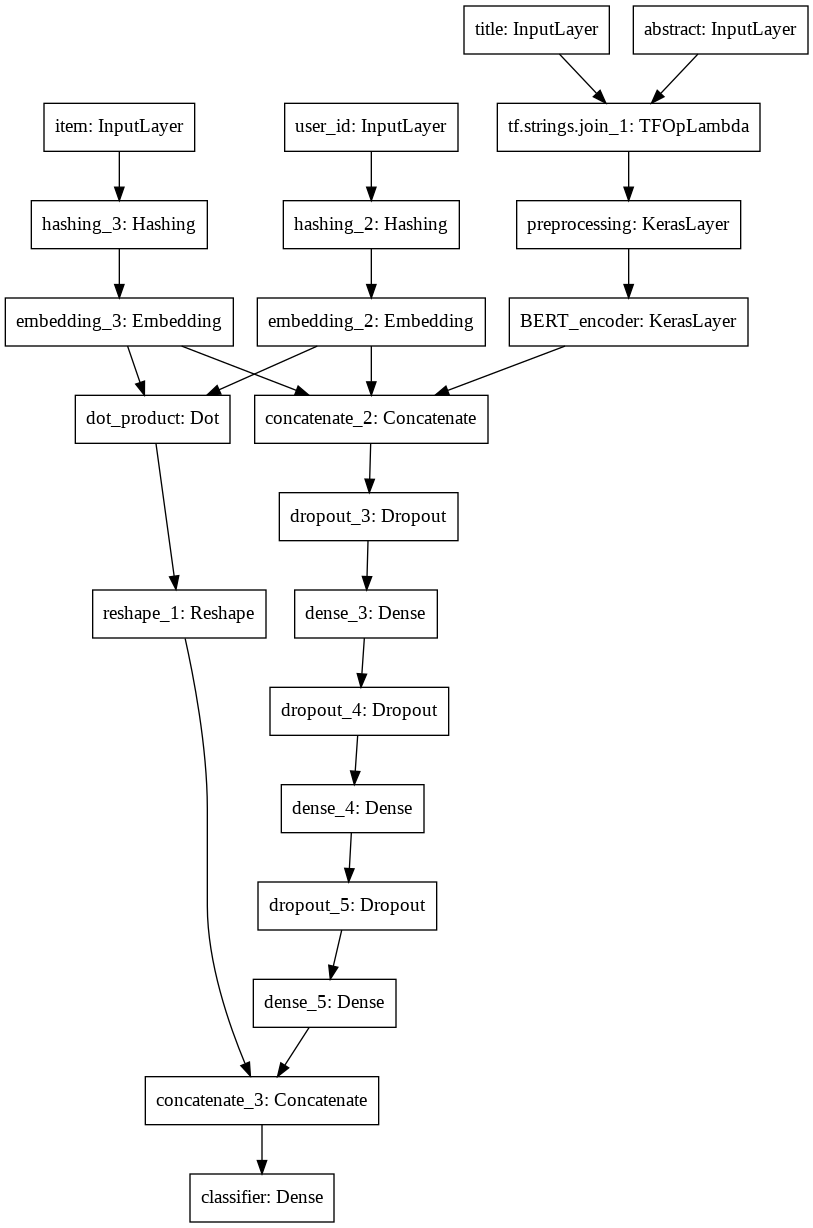

In [ ]:
tf.keras.utils.plot_model(classifier_model, path+f'/model_graph_simple.png')

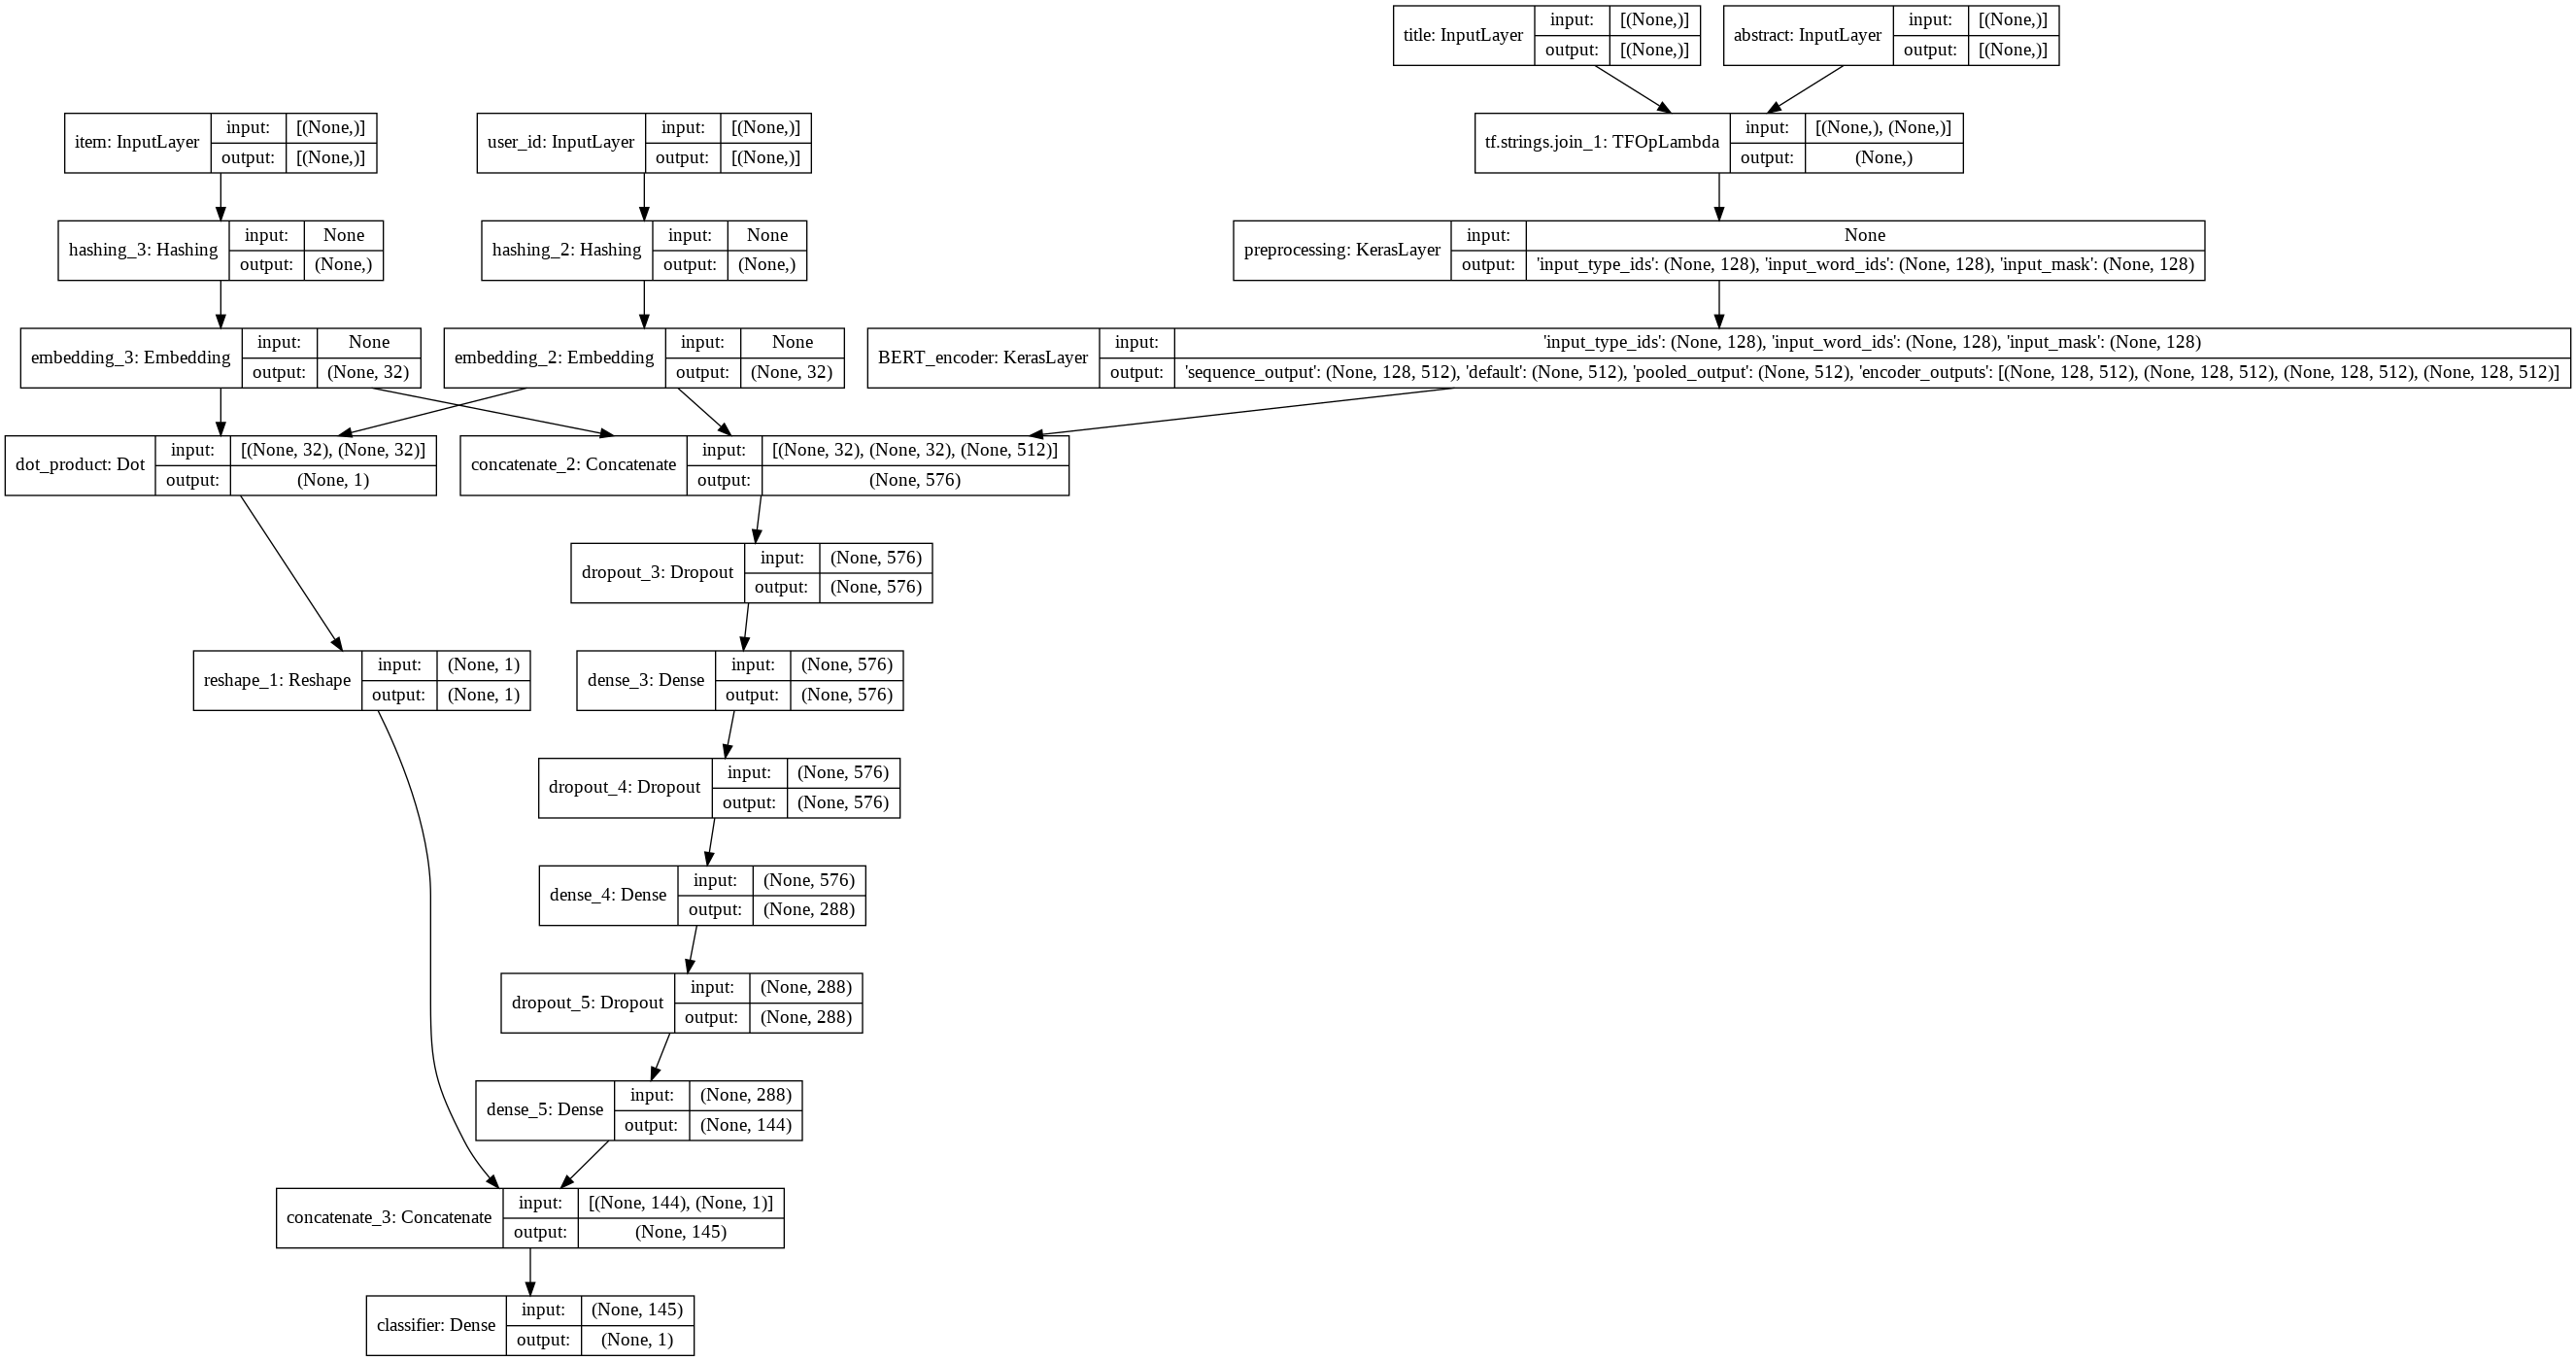

In [ ]:
tf.keras.utils.plot_model(classifier_model, path+f'/model_graph.png', show_shapes=True)

## Loss function and Metrics

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = [
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
]

##Optimizer

In [ ]:
epochs = 10
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

##Load Model and Train

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

###Checkpoints

In [ ]:
checkpoint_filepath = path+'tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    )

In [ ]:
# The model weights (that are considered the best) are loaded into the model.
classifier_model.load_weights(checkpoint_filepath)

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs,
                               callbacks=[model_checkpoint_callback])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['size'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


11496/11496 [==============================] - 2118s 184ms/step - loss: 0.2004 - fp: 1166.3427 - tp: 26266.2580 - tn: 146814.2529 - fn: 9721.1394 - accuracy: 0.9409 - precision: 0.9580 - recall: 0.7298 - auc: 0.9204 - val_loss: 0.2140 - val_fp: 981.0000 - val_tp: 17638.0000 - val_tn: 97603.0000 - val_fn: 6394.0000 - val_accuracy: 0.9399 - val_precision: 0.9473 - val_recall: 0.7339 - val_auc: 0.9224
Epoch 2/10
11496/11496 [==============================] - 2110s 184ms/step - loss: 0.1894 - fp: 868.2375 - tp: 26657.6540 - tn: 147112.3581 - fn: 9329.7434 - accuracy: 0.9446 - precision: 0.9684 - recall: 0.7406 - auc: 0.9272 - val_loss: 0.2127 - val_fp: 754.0000 - val_tp: 17581.0000 - val_tn: 97830.0000 - val_fn: 6451.0000 - val_accuracy: 0.9412 - val_precision: 0.9589 - val_recall: 0.7316 - val_auc: 0.9220
Epoch 3/10
11496/11496 [==============================] - 2103s 183ms/step - loss: 0.1811 - fp: 720.4430 - tp: 26913.7748 - tn: 147260.1526 - fn: 9073.6226 - accuracy: 0.9468 - precision

In [ ]:
def plot_metrics(history):
  plt.style.use('dark_background')
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
            linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

Metrics history from the latest checkpoint.

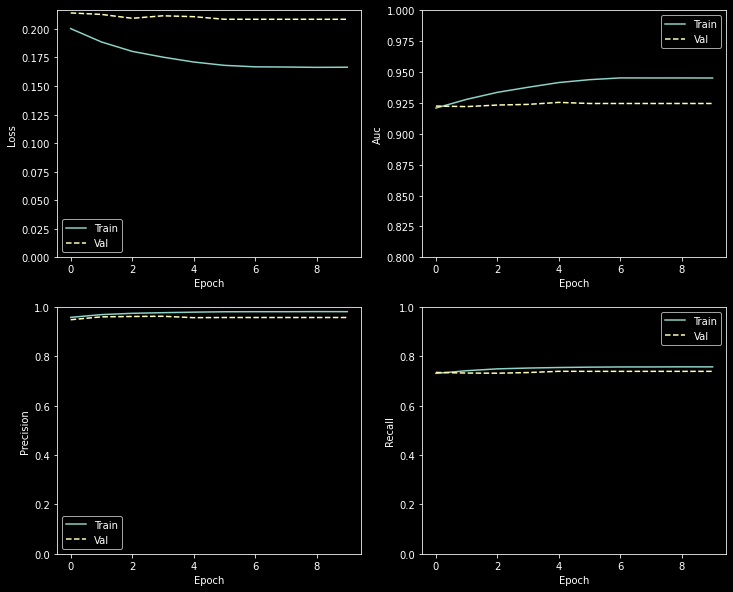

In [ ]:
plot_metrics(history)

#Evaluate Model

In [ ]:
results = classifier_model.evaluate(test_ds)

3832/3832 [==============================] - 293s 76ms/step - loss: 0.2063 - fp: 780.0000 - tp: 17881.0000 - tn: 97755.0000 - fn: 6201.0000 - accuracy: 0.9431 - precision: 0.9582 - recall: 0.7425 - auc: 0.9252


In [ ]:
for name, value in zip(classifier_model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.20632344484329224
fp :  780.0
tp :  17881.0
tn :  97755.0
fn :  6201.0
accuracy :  0.9430665969848633
precision :  0.9582015872001648
recall :  0.7425047755241394
auc :  0.925247311592102



##Plot accuracy and loss over time

dict_keys(['loss', 'fp', 'tp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_fp', 'val_tp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])
[0.940872311592102, 0.9446429014205933, 0.9468557834625244, 0.9478779435157776, 0.9486336708068848, 0.9491420388221741, 0.9493486285209656, 0.949343204498291, 0.9494927525520325, 0.9494247436523438]
[0.9398528933525085, 0.9412392973899841, 0.9413534998893738, 0.9419814944267273, 0.9420385360717773, 0.9421119689941406, 0.9421119689941406, 0.9421119689941406, 0.9421119689941406, 0.9421119689941406]
[0.20027732849121094, 0.18861663341522217, 0.1803642362356186, 0.17531335353851318, 0.17103978991508484, 0.16811726987361908, 0.16681143641471863, 0.16664043068885803, 0.1663542538881302, 0.16647695004940033]
[0.21403013169765472, 0.2127315253019333, 0.2093304991722107, 0.21150943636894226, 0.2107512354850769, 0.20846587419509888, 0.20846585929393768, 0.2084658443927765, 0.20846587419509888, 0.2084658

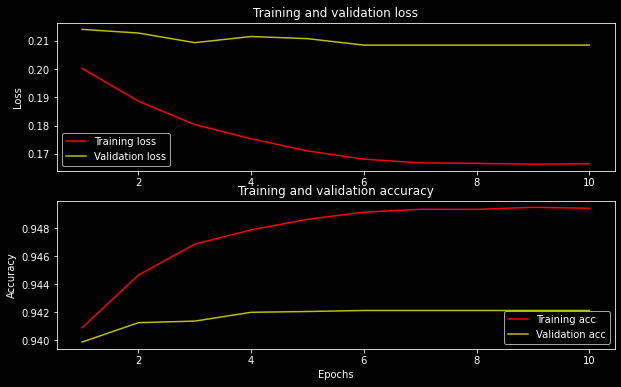

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

for x in [acc, val_acc, loss, val_loss]:
    print(x)

plt.style.use('dark_background')

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

##Export for Inference

In [ ]:
dataset_name = 'Inspire_Mind'
timestr = time.strftime("%Y%m%d-%H%M")
saved_model_path = f"{path}{dataset_name}_FM_{timestr}"

classifier_model.save(saved_model_path, include_optimizer=False)

##Evaluate on Cold Start Users
The 90% of users not selected for model training, validation, and testing can be used as an extra test set. Here, the users are cold-started (the model is evaluated without training on the users click history).

In [ ]:
#get the complement of the original sample
df_cold = pd.read_pickle(path+'news.pkl')
df_cold = df_cold[~df_cold['user_id'].isin(sample)]
df_cold.abstract = df_cold.abstract.fillna("")

#an arbitrary subset of these observations can be used for quick testing
# df_cold_select = df_cold.iloc[:100000]
df_cold_select = df_cold

#create a dataset of cold start users
cold_ds = df_to_dataset(df_cold_select.drop('click', axis=1), df_cold_select.pop('click'), batch_size=batch_size)
cold_ds = cold_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
cold_results = classifier_model.evaluate(cold_ds)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['size'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


165060/165060 [==============================] - 12824s 78ms/step - loss: 0.2105 - fp: 33949.0000 - tp: 757444.0000 - tn: 4219464.0000 - fn: 271046.0000 - accuracy: 0.9423 - precision: 0.9571 - recall: 0.7365 - auc: 0.9195


In [ ]:
for name, value in zip(classifier_model.metrics_names, cold_results):
  print(name, ': ', value)
print()

loss :  0.21046993136405945
fp :  33949.0
tp :  757444.0
tn :  4219464.0
fn :  271046.0
accuracy :  0.9422566294670105
precision :  0.9571022391319275
recall :  0.7364621758460999
auc :  0.9194666147232056



In [ ]:
#cold sample predictions
cold_predicts = classifier_model.predict(cold_ds)
print(cold_predicts)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['size'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


# Conclusion



##Future Work

*   Adding the size variable to the model
*   Create a coldstart for items (news articles)
*   Compare other network architectures
* Hyperparameter tuning with Bayesian Optimization  
*  Consider model implementation in TFX and Tensorflow Serving

